In [112]:
import numpy as np
import os
from matplotlib import pyplot as plt
from astropy.io import fits
# from astropy import stats
# import shutil
from astropy.visualization import simple_norm

from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from scipy.ndimage import shift
from matplotlib.colors import LogNorm

from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
from astroquery.ned import Ned
import astropy.units as u
from astropy.nddata import Cutout2D
# import pylab as plt
from scipy import interpolate
from matplotlib.colors import ListedColormap
# import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from IPython.display import clear_output
# from pyBBarolo import *
from scipy import stats

Построение карты круговых скоростей.

Моя идея создать карты радиусов $r$ и углов $\phi$, и просто пробежать по массиву и, используя кривую вращения (как я поняла, в той статье она уже с учетом наклона галактики i ), в каждый пиксель положить $ V(r_{ij}) * cos(\phi_{ij})$

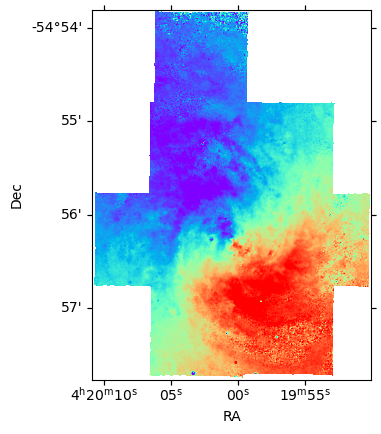

In [115]:
import warnings
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS, FITSFixedWarning
from astropy.utils.data import get_pkg_data_filename

filename = get_pkg_data_filename('./data/NGC1566_vel_Ha.fits')

hdu = fits.open(filename)[0]
with warnings.catch_warnings():
    # Ignore a warning on using DATE-OBS in place of MJD-OBS
    warnings.filterwarnings('ignore', message="'datfix' made the change",
                            category=FITSFixedWarning)
    wcs = WCS(hdu.header)

fig = plt.figure()
fig.add_subplot(111, projection=wcs)
norm = simple_norm(hdu.data, "linear", percent=95)
plt.imshow(hdu.data, cmap="rainbow", origin="lower", norm=norm)
# plt.imshow(hdu.data, origin='lower', cmap="rainbow", norm=norm)
plt.xlabel('RA')
plt.ylabel('Dec')

In [ ]:
# wcs_coord = np.empty(shape=(hdu.data.shape[0],hdu.data.shape[1], 2))
# print(wcs_coord.shape)

(1187, 898, 2)


In [ ]:
# for i in range(wcs_coord.shape[0]):
#     for j in range(wcs_coord.shape[1]):
#         wcs_coord[i, j] = wcs.wcs_pix2world(i, j, 1)
        

In [ ]:
galname = "NGC1566"

# coordinates NGC1566
RA0, DEC0 = wcs.wcs_pix2world(hdu.header["CRPIX1"], hdu.header["CRPIX2"], 1)
print(RA0, DEC0)

(1187, 898, 2)
65.001846393711 -54.93791205151501


In [ ]:
# wcs_coord[:,:, 0] = wcs_coord[:, :, 0] - RA0
# wcs_coord[:,:, 1] = wcs_coord[:, :, 1] - DEC0

In [127]:
# print(wcs_coord)

In [155]:
distance_map = np.empty(shape=hdu.data.shape)
distance_map_pix = np.empty(shape=hdu.data.shape)
print(distance_map.shape)

(1187, 898)


In [ ]:
# pix-coordinates NGC1566
i0 = hdu.header["CRPIX1"]
j0 = hdu.header["CRPIX2"]
print(i0, j0)

451.21399818598 447.31895706293


In [226]:
for i in range(distance_map.shape[0]):
    for j in range(distance_map.shape[1]):
        # distance_map[i, j] = np.sqrt(wcs_coord[i, j, 0]**2 + wcs_coord[i, j, 1]**2)
        distance_map_pix[i, j] = np.sqrt((i-i0)**2 + (j-j0)**2)

In [161]:
# plt.subplot(121)
# im = plt.imshow(wcs_coord[:, :, 0], origin="lower", cmap="rainbow")
# plt.scatter(hdu.header["CRPIX1"], hdu.header["CRPIX2"])
# plt.contour(wcs_coord[:, :, 0])
# plt.colorbar(im)

# plt.subplot(122)
# im = plt.imshow(wcs_coord[:, :, 1], origin="lower", cmap="rainbow")
# plt.scatter(hdu.header["CRPIX1"], hdu.header["CRPIX2"])
# plt.contour(wcs_coord[:, :, 1])
# plt.axis('off')
# plt.colorbar(im)

# plt.show()

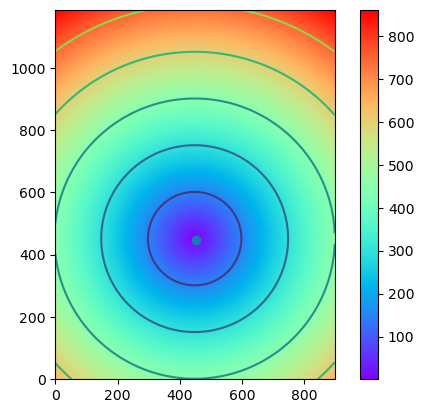

In [ ]:
# plot distance_map (pix)
im = plt.imshow(distance_map_pix, origin="lower", cmap="rainbow")
plt.scatter(hdu.header["CRPIX1"], hdu.header["CRPIX2"])
plt.contour(distance_map_pix)
plt.colorbar(im)
plt.show()

(1187, 898)


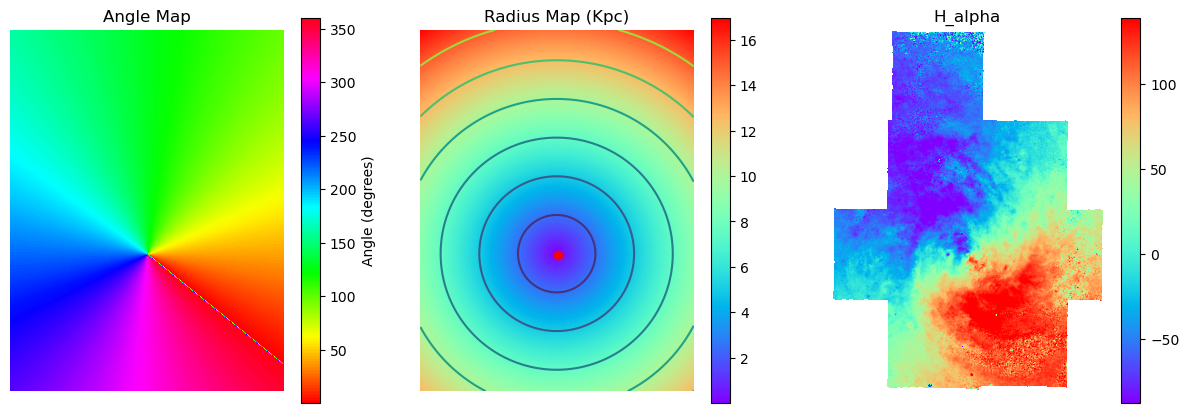

In [244]:
def create_angle_map(image_size, pa_deg, center_x, center_y):
    # Define the center of the image
    # center_x, center_y = image_size[0]//2, image_size[1]//2
    
    # Convert the position angle from degrees to radians
    pa_rad = np.radians(pa_deg)
    
    # Create a grid of coordinates for the image
    x = np.arange(image_size[1])
    y = np.arange(image_size[0])
    X, Y = np.meshgrid(x - center_x, y - center_y)  # Create coordinate grid centered at (0,0)
    
    # Calculate the angle for each pixel (in radians) relative to the center (0,0)
    angle_map = np.arctan2(Y, X)  # Angle in radians from the center
    
    # Adjust for the PA (rotate the angle to match the PA of the galaxy)
    angle_map += pa_rad - np.pi  # Apply the position angle offset
    
    # Normalize the angle to be within [0, 2π] range
    angle_map = np.mod(angle_map, 2 * np.pi)
    
    # Convert the angle map to degrees for easier interpretation
    angle_map_deg = np.degrees(angle_map)
    
    return angle_map_deg

# Parameters
shape = hdu.data.shape
print(shape)
image_size = shape
pa_deg = 219

# Create the angle map
angle_map = create_angle_map(image_size, pa_deg, hdu.header["CRPIX1"], hdu.header["CRPIX2"])

# Plot the angle map
plt.figure(figsize=[15, 5])
plt.subplot(131)
# fig.add_subplot(121, projection=wcs)
plt.imshow(angle_map, cmap='hsv', origin='lower')
plt.colorbar(label="Angle (degrees)")
plt.axis("off")
plt.title("Angle Map")

dist = 20.3 * 1000 
distance_map = dist*np.tan(np.radians(distance_map_pix*hdu.header["CD2_2"]))
# distance_map = dist*distance_map_pix*np.tan(hdu.header["CD2_2"]*np.pi/180)
plt.subplot(132)
im = plt.imshow(distance_map, origin="lower", cmap="rainbow")
plt.scatter(hdu.header["CRPIX1"], hdu.header["CRPIX2"], c="r")
plt.contour(distance_map)
plt.colorbar(im)
plt.axis("off")
plt.title("Radius Map (Kpc)")

plt.subplot(133)
norm = simple_norm(hdu.data, "linear", percent=95)
im = plt.imshow(hdu.data, origin="lower", cmap="rainbow", norm = norm)
# plt.scatter(hdu.header["CRPIX1"], hdu.header["CRPIX2"])
plt.colorbar(im)
plt.axis("off")
plt.title(r"H_alpha")
plt.show()


In [ ]:

dataHa, hdr = fits.getdata("data/NGC1566_vel_Ha.fits", header=True)
dataS, _ = fits.getdata("data/NGC1566_vel_stars.fits", header=True)

# norm = simple_norm(dataS, "sqrt", percent=99.)
# normh = simple_norm(dataHa, "sqrt", percent=99.)
# normm = simple_norm(dataHa-dataS, "sqrt", percent=99.)


In [137]:
curve_rot = '''2.168284789644016; 149.28571428571425
4.239482200647252; 193.57142857142853
6.310679611650487; 198.57142857142853
8.31715210355987; 196.4285714285714
10.453074433656958; 194.99999999999994
12.45954692556634; 193.57142857142853
14.466019417475728; 190.71428571428567
16.601941747572813; 185.71428571428567
18.67313915857605; 179.28571428571425
20.679611650485437; 173.57142857142856
22.81553398058252; 172.1428571428571
24.88673139158576; 171.4285714285714
26.893203883495136; 172.1428571428571
29.02912621359223; 171.4285714285714
31.03559870550161; 167.1428571428571
33.042071197411005; 165.71428571428567
35.17799352750808; 164.99999999999997
37.24919093851132; 166.4285714285714
39.25566343042071; 173.57142857142856
41.391585760517785; 174.28571428571425
43.33333333333333; 171.4285714285714
45.404530744336554; 174.99999999999994
47.605177993527505; 169.99999999999994
49.61165048543688; 162.1428571428571'''


curve_rot = curve_rot.split('\n')
R = np.array([float(_.split(';')[0]) for _ in curve_rot])
V = np.array([float(_.split(';')[1]) for _ in curve_rot])

(0.0, 250.0)

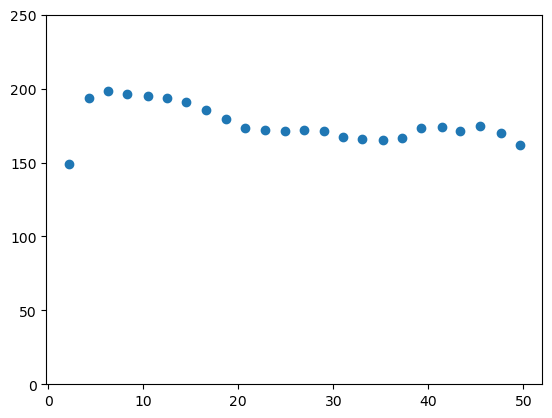

In [138]:
plt.scatter(R, V)
plt.ylim([0, 250])

Я решила интерполировать кубическими сплайнами кривую вращения, но не уверена, можно ли так делать...

In [ ]:
from scipy.interpolate import CubicSpline
spl = CubicSpline(R, V)

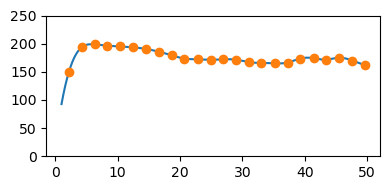

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4, 2))
xnew = np.linspace(1, R[-1], num=1001)
plt.plot(xnew, spl(xnew))
plt.plot(R, V, 'o', label='data')
plt.ylim([0, 250])
plt.tight_layout()
plt.show()

In [ ]:
print(hdu.data[int(hdu.header["CRPIX1"]),int(hdu.header["CRPIX2"])])
v_0 = hdu.data[int(hdu.header["CRPIX1"]),int(hdu.header["CRPIX2"])]

-31.425231220766932


In [198]:
model_vel_map = np.empty(angle_map.shape)
model_vel_map_1 = np.empty(angle_map.shape)
incl = 31 
for i in range(model_vel_map.shape[0]):
    for j in range(model_vel_map.shape[1]):
        # print(f"spline = {spl(distance_map[i, j])}")
        model_vel_map[i, j] = spl(distance_map[i, j])/np.sin(np.radians(incl))*np.cos(np.radians(angle_map[i, j]))
        model_vel_map_1[i, j] = spl(distance_map[i, j])*np.cos(np.radians(angle_map[i, j]))


Text(0.5, 1.0, 'residual')

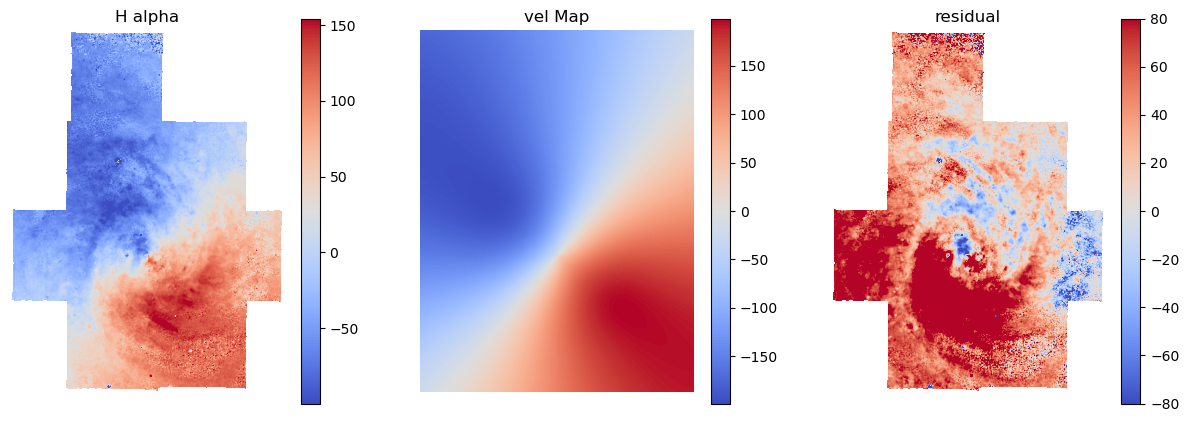

In [243]:
# Plot the model map
plt.figure(figsize=[15, 5])
plt.subplot(131)
norm=simple_norm(dataHa, "linear", percent=99.)
im = plt.imshow(dataHa, cmap='coolwarm', origin='lower', norm=norm)
plt.colorbar(im)
# im.set_clim(vmin=-150, vmax=150)
plt.axis("off")
plt.title("H alpha")

plt.subplot(132)
im = plt.imshow(model_vel_map_1, cmap='coolwarm', origin='lower')
# im.set_clim(vmin=-80, vmax=80)
plt.colorbar(im)
plt.axis("off")
plt.title("vel Map")

palette = ListedColormap(['#2b3cce','#4c5fdd','#6b80e8','#8ca0f2','#b0c1f9','#d6e1ff','#ffd8ca','#f1b6a1','#e2957b','#d07356','#bd5133','#a82a11'])
plt.subplot(133)
resid = dataHa/np.sin(np.radians(incl)) - model_vel_map_1
norm = simple_norm(resid, "linear", percent=99)
im = plt.imshow(resid, cmap='coolwarm', origin='lower', norm = norm)
# im = plt.imshow(resid, cmap=palette, origin='lower', norm = norm)
im.set_clim(vmin=-80, vmax=80)
plt.colorbar(im)
plt.axis("off")
plt.title("residual")